<a href="https://colab.research.google.com/github/javierdealba/Notes/blob/main/Deteccion_peatones_(Matiriz_y_comentarios).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('/content/drive/MyDrive/Tec/n_a')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content
Current working directory: /content/drive/MyDrive/Tec/n_a


In [ ]:
# Se definen algunas variables que se utilizarán más adelante
datadir = "Positive" # directorio que contiene los datos positivos
dataset = "pedestrians128x64" # dataset es el nombre del conjunto de datos
datafile = "%s/%s.tar.gz" % (datadir, dataset) # datafile es la ruta al archivo comprimido que contiene los datos
datadirneg = "Negative" # datadirneg es el directorio que contiene los datos negativos

In [ ]:
extractdir = "%s/%s" % (datadir, dataset) # Define la ruta donde se extraerán los datos del archivo comprimido

In [ ]:
# Funcion para extraer el archivo comprimido
def extract_tar(datafile, extractdir):
    try:
        import tarfile # Se intenta importar el módulo tarfile para trabajar con archivos tar
    except ImportError:
        raise ImportError("No tienes instalado el módulo 'tarfile'.")

    tar = tarfile.open(datafile) # Se abre el archivo tar especificado por datafile
    tar.extractall(path=extractdir) # Se extrae en el directorio extractdir
    tar.close() # Se cierra
    print("%s Extraído exitosamente en %s" % (datafile, extractdir))

In [ ]:
# Llama a la función extract_tar para extraer el archivo tar especificado por datafile en el directorio datadir
# extract_tar(datafile, datadir)

In [ ]:
# Estas líneas importan los módulos necesarios para trabajar con imágenes y para visualizar los resultados
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

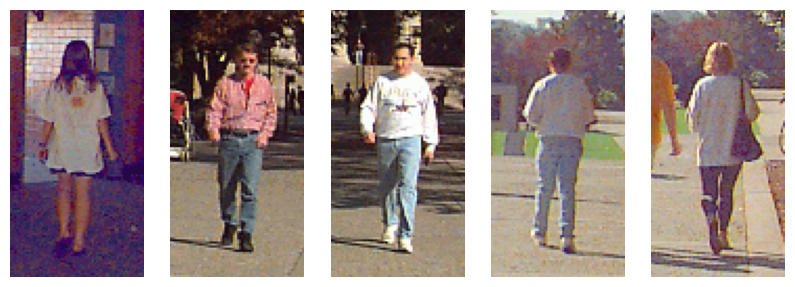

In [ ]:
# Crea una figura con un tamaño específico para las visualizaciones posteriores
plt.figure(figsize=(10, 6)) 

# Este bucle itera cinco veces y muestra cinco imágenes de muestra como subplots
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [ ]:
# Se definen los parámetros para el descriptor HOG (Histogram of Oriented Gradients)
# El descriptor HOG se utiliza para extraer características de las imágenes
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9

# Se crea una instancia del descriptor HOG con los parámetros anteriores
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [ ]:
# Se importan los módulos necesarios
import numpy as np
import random

# Establece una semilla aleatoria
random.seed(42)

# Crea una lista vacía para almacenar las características HOG de las imágenes positivas
X_pos = []

# Se itera sobre una muestra aleatoria de 400 números en el rango de 0 a 899
# Para cada número i, se construye el nombre del archivo de imagen filename utilizando el directorio de extracción extractdir y el número i
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('No se pudo encontrar la imagen %s' % filename)
        continue

    # Se calculan las características HOG de la imagen y se agrega a la lista
    X_pos.append(hog.compute(img, (64, 64)))

No se pudo encontrar la imagen Positive/pedestrians128x64/per00000.ppm


In [ ]:
# Se convierte en un array NumPy de tipo np.float32
X_pos = np.array(X_pos, dtype=np.float32)

# Se crea un array que contiene solo el valor 1 (indicando que son imágenes positivas)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

# Se imprimen las dimesiones
X_pos.shape, y_pos.shape

((399, 1980), (399,))

In [ ]:
# Se definen variables relacionadas con los datos negativos al igual que se hizo con los positivos
negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % (datadirneg, negset)
negdir = "%s/%s" % (datadirneg, negset)

# Extrae el archivo tar de datos negativos
# extract_tar(negfile, datadirneg)

In [ ]:
# Cargar y proceso de los datos negativos
import os # Se carga para trabajar con el sistema de archivos

# Define el alto y el ancho de la región de interés (ROI)
hroi = 128
wroi = 64

# Se crea una lista vacía para almacenar las características HOG de las imágenes negativas
X_neg = []

# Se itera sobre los archivos de negdir
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)

    # Redimensiona a un tamaño de 512 por 512
    img = cv2.resize(img, (512, 512))

    # Itera cinco veces, extrayendo cinco regiones de interés aleatorias de la imagen redimensionada
    for j in range(5):

      # Se generan coordenadas aleatorias dentro de los límites de la imagen
      rand_y = random.randint(0, img.shape[0] - hroi)
      rand_x = random.randint(0, img.shape[1] - wroi)

      # Extrae la región de interés (roi) de tamaño (hroi, wroi) desde la imagen utilizando el recorte de segmento
      roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]

      # Se calculan las características HOG de la región de interés
      X_neg.append(hog.compute(roi, (64, 64)))

In [ ]:
# la lista X_neg se convierte en un array NumPy de tipo np.float32
X_neg = np.array(X_neg, dtype=np.float32)

# Crea un array que contiene el valor -1 para indicar que son imágenes negativas
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

((180, 1980), (180,))

In [ ]:
# concatenan las características HOG y las etiquetas de las imágenes positivas (X_pos y y_pos)
# con las características HOG y las etiquetas de las imágenes negativas (X_neg y y_neg)
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))
# El resultado es una matriz X que contiene todas las características HOG de las imágenes
# y un vector y que contiene las etiquetas correspondientes.

In [ ]:
# Ahora se dividen los datos en un conjunto de entrenamiento y un conjunto de prueba
# utilizando train_test_split del módulo model_selection de scikit-learn
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    # Se pasa la matriz de características X y el vector de etiquetas Y
    # Se especifica que el tamaño del conjunto de prueba será del 20% del total de datos
    # Se establece la semilla aleatoria en 42
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Se decalaran las funciones auxiliares para entrenar y evaluar un clasificador SVM (Support Vector Machine)
# utilizando el módulo cv2.ml de OpenCV y el módulo metrics de scikit-learn.

# Crea una instancia de SVM utilizando cv2.ml.SVM_create(), entrena el clasificador con las 
# características de entrenamiento X_train y las etiquetas correspondientes y_train,
# y devuelve el clasificador entrenado
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

# Realiza la predicción con el clasificador SVM svm en las características X y compara las etiquetas predichas
# con las etiquetas reales y utilizando la métrica de exactitud (accuracy_score) del módulo metrics.
# Devuelve el valor de exactitud obtenido.
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

In [ ]:
# Entrena un clasificador SVM utilizando las características de entrenamiento y las etiquetas correspondientes
svm = train_svm(X_train, y_train)

In [ ]:
# Evalúa la precisión del clasificador en el conjunto de entrenamiento
score_svm(svm, X_train, y_train)

1.0

In [ ]:
# Evalúa la precisión del clasificador en el conjunto de prueba
score_svm(svm, X_test, y_test)

0.6896551724137931

[[ 0 36]
 [ 0 80]]


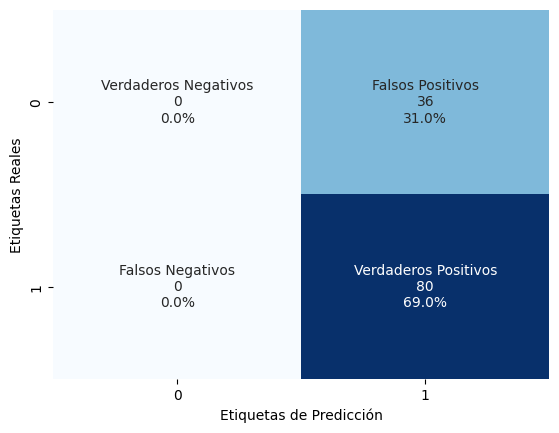

In [ ]:
# Obtener las predicciones del modelo en el conjunto de prueba
_, y_pred_antes = svm.predict(X_test)

# Crear la matriz de confusión utilizando sklearn
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred_antes)

# Imprimir la matriz de confusión
print(confusion)


import seaborn as sns

txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
frecuencia = ["{0:0.0f}".format(value) for value in confusion.flatten()]
porcentaje = ["{0:.1%}".format(value) for value in confusion.flatten()/np.sum(confusion)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(txt,frecuencia,porcentaje)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues', cbar=False)
ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
plt.show()

In [ ]:
score_train = []
score_test = []

for j in range(3):
  # Bucle en el que se entrena un clasificador SVM, se calcula la precisión en el conjunto de entrenamiento y el
  # conjunto de prueba, y se actualizan los conjuntos de entrenamiento y prueba.
  svm = train_svm(X_train, y_train)
  score_train.append(score_svm(svm, X_train, y_train))
  score_test.append(score_svm(svm, X_test, y_test))
    
  # Se verifica si hay falsos positivos en el conjunto de prueba
  _, y_pred = svm.predict(X_test)
  false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
  if not np.any(false_pos):
      print('Hecho')
      break
  
  # Si hay falsos positivos, se concatenan las características y las etiquetas correspondientes de los falsos positivos
  # en los conjuntos de entrenamiento y se repite el proceso para obtener un nuevo clasificador SVM.
  X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
  y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

Hecho


In [ ]:
# Obtener las predicciones del modelo en el conjunto de prueba
_, y_pred2 = svm.predict(X_test)

# Crear la matriz de confusión utilizando sklearn
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred2)

# Imprimir la matriz de confusión
print(confusion)

[[36  0]
 [ 0 80]]


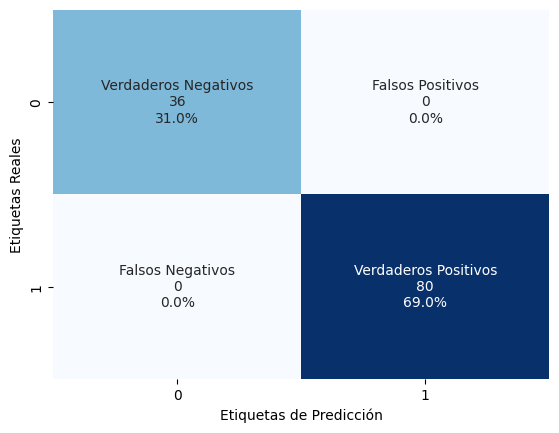

In [ ]:
# Se utiliza el heatmap de seaborn para visualizar la matriz de confusión de una manera más dinámica

import seaborn as sns

txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
frecuencia = ["{0:0.0f}".format(value) for value in confusion.flatten()]
porcentaje = ["{0:.1%}".format(value) for value in confusion.flatten()/np.sum(confusion)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(txt,frecuencia,porcentaje)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues', cbar=False)
ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
plt.show()

In [ ]:
# Puntuaciones de precisión obtenidas en el conjunto de entrenamiento
score_train

In [ ]:
# Puntuaciones de precisión obtenidas en el conjunto de prueba
score_test

[0.6896551724137931, 1.0]

In [ ]:
# Se carga una imagen de prueba
img_test = cv2.imread('Positive/peaton.PNG')

In [ ]:
# Se establece el tamaño del desplazamiento utilizado para deslizar una ventana por la imagen
stride = 15
found = []

# Se realiza un bucle anidado que recorre las coordenadas de inicio de la ventana a través de la imagen
for ystart in np.arange(0, img_test.shape[0], stride):
  for xstart in np.arange(0, img_test.shape[1], stride):

    # Verifica si las coordenadas de la ventana están dentro de los límites de la imagen
    if ystart + hroi > img_test.shape[0]:
      continue
    if xstart + wroi > img_test.shape[1]:
      continue

    # Extrae la región de interés roi
    roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]

    # Calcula las características HOG
    feat = np.array([hog.compute(roi, (64, 64))])

    # Se realiza la predicción con el clasificador SVM
    _, ypred = svm.predict(feat)

    # Verifica si la predicción realizada por el clasificador SVM (ypred) es igual a 1
    if np.allclose(ypred, 1):

      # Agrega la ubicación de la ventana encontrada al listado found.
      # Esto significa que se ha detectado un peatón en esa región de la imagen.
      found.append((ystart, xstart, hroi, wroi))

In [ ]:
# Se crea un nuevo objeto hog de la clase cv2.HOGDescriptor con los mismos parámetros que se
# utilizaron para entrenar el clasificador SVM
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [ ]:
# Se obtienen los coeficientes de la función de decisión (rho) y los vectores de soporte (sv) del clasificador SVM.
# Estos coeficientes y vectores se establecen en el detector HOG utilizando el método setSVMDetector del objeto hog.
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

In [ ]:
# Se crea el detector HOG predeterminado para la detección de personas en OpenCV.
hogdef = cv2.HOGDescriptor()
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [ ]:
# detección de múltiples objetos en la imagen de prueba.
# El resultado se almacena en la variable found, que contendrá las coordenadas y dimensiones de los rectángulos
# que representan los objetos detectados.
found, _ = hogdef.detectMultiScale(img_test)

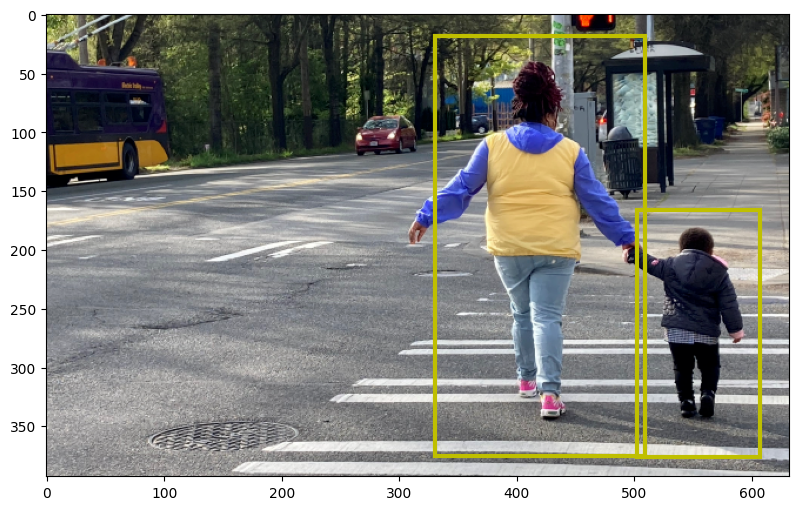

In [ ]:
# Visualizamos la imagen de prueba. Se agregan rectángulos utilizando el método add_patch
# para cada objeto encontrado en la imagen.
# Los rectángulos se dibujan utilizando las coordenadas y dimensiones proporcionadas en found.
# Finalmente, se guarda la figura como un archivo de imagen llamado 'detected.png'.

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.savefig('detected.png')